### Robust classifier: MNIST 0/1 case

This code is an attempt to solve robust classification problem for a binary MNIST dataset. Here I train a classifier with BCE-loss, construct optimal perturbation and then train a robust classifier using sklern and numpy.

### Imports

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Load the dataset
mnist = fetch_openml('mnist_784', as_frame=False, cache=False)
# featch_mldata method to load MNIST returns data and target as uint8 which we convert to float32 and int64
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
# Leave only samples with digits 0 and 1
y_bin = y[(y == 0) | (y == 1)]
X_bin = X[(y == 0) | (y == 1)]
# See the target rate (dataset is balanced)
print("Target rate: ", y_bin.mean())

Target rate:  0.5329499323410013


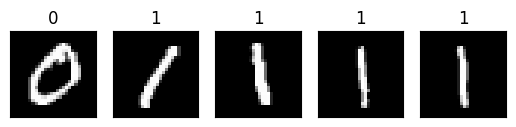

In [ ]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img, cmap = 'gray')
        plt.xticks([])
        plt.yticks([])
        plt.title(y)

plot_example(X_bin, y_bin)

### Solving original classification problem


In [ ]:
scaler = MinMaxScaler()
X_bin_norm = scaler.fit_transform(X_bin)
X_train, X_test, y_train, y_test = train_test_split(X_bin_norm, y_bin, test_size=0.3)

logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
accuracy = logistic_model.score(X_test, y_test)

accuracy #всё норм, качество овер99.9%

0.9993234100135318

### Solving inner maximization problem
To build a robust classifier we need to solve two problems:
+ Inner optimization problem: find the solution to the worse-case adversarial attack
+ Train classifier with the robust optimization problem

The inner optimization problem stated as

\begin{equation}
\DeclareMathOperator*{\maximize}{maximize}
\maximize_{\|\delta\| \leq \epsilon} \ell(w^T (x+\delta), y) \equiv \maximize_{\|\delta\| \leq \epsilon} L(y \cdot (w^T(x+\delta) + b)).
\end{equation}

has closed-form solution in binary case:

\begin{equation}
\delta^\star = - y \epsilon \cdot \mathrm{sign}(w)
\end{equation}


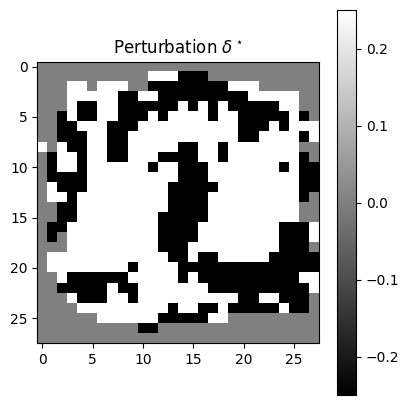

In [ ]:
# TODO: Construct a valid perturbation and plot it.
epsilon = 0.25
w = logistic_model.coef_[0]
b = logistic_model.intercept_[0]
delta_star = -epsilon * np.sign(w)
X_test_perturbed = X_test + delta_star
X_test_perturbed = np.clip(X_test_perturbed, 0, 1)

plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.imshow(delta_star.reshape(28, 28), cmap='gray')
plt.title("Perturbation $\delta^\star$")
plt.colorbar()
#пертурбация, как я вижу, призвана заглушить в картинке качества, присущие и нулю, и единичке, и усилить шум -- то, что усложняет классификацию

In [ ]:
accuracy_perturbed = logistic_model.score(X_test_perturbed, y_test)
accuracy_perturbed # как видим, точность стала такая же примерно, как и у random классифаера

0.47316193053676137

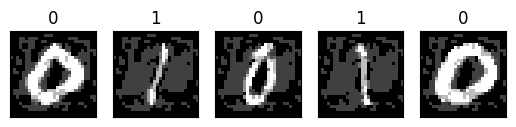

In [ ]:
plot_example(X_test_perturbed, y_test)
#пертурбацию немного видно -- точность становится минимальной, когда эпсилон достаточно большой --
#но чем он больше, тем проще пертурбацию распознать. энивей, цифры всё так же однозначно различимы.

### Training a robust classifier
This problem is equivalent to min-max problem in the case of binary classification:

\begin{equation}
\DeclareMathOperator*{\minimize}{minimize}
\minimize_{w,b} \frac{1}{D}\sum_{(x,y) \in D} L \left(y \cdot (w^Tx + b) - \epsilon \|w\|_* \right )
\end{equation}


In [ ]:
from sklearn.base import BaseEstimator

class RobustLogisticRegression(BaseEstimator):

    def __init__(self, epsilon=0.2, learning_rate=3e-4, n_iter=50):
        self.epsilon = epsilon
        self.learning_rate = learning_rate
        self.n_iter = n_iter
        self.w = None
        self.b = None

    def fit(self, X, y):
        self.w = np.zeros(X.shape[1])
        self.b = 0
        for i in range(self.n_iter):
            gradient_w, gradient_b = self._compute_gradient(X, y)
            self.w -= self.learning_rate * gradient_w
            self.b -= self.learning_rate * gradient_b
            if self.score(X, y) >= 0.996: #чтобы быстрее работало, и эта точность приемлемая
              break

    def predict(self, X):
        scores = np.dot(X, self.w) + self.b
        return np.where(scores > 0, 1, 0)

    def _compute_gradient(self, X, y):
        n = X.shape[0]
        predictions = self._sigmoid(np.dot(X, self.w) + self.b)
        error = predictions - y
        gradient_w = np.dot(X.T, error) / n + self.epsilon * np.sign(self.w)
        gradient_b = np.sum(error) / n
        return gradient_w, gradient_b

    def _sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def score(self, X, y):
        predictions = self.predict(X)
        correct_predictions = np.sum(predictions == y)
        accuracy = correct_predictions / len(y)
        return accuracy

In [ ]:
robust_lr = RobustLogisticRegression()
robust_lr.fit(X_train, y_train)
X_test_perturbed = np.clip(X_test + delta_star, 0, 1)
accuracy_perturbed = robust_lr.score(X_test_perturbed, y_test)
print(accuracy_perturbed)
#а теперь стало норм, точность выше 99%

0.9963915200721696


In [ ]:
accuracy_non_perturbed = robust_lr.score(X_test, y_test)
accuracy_non_perturbed
#качество, конечно, упало, но это обусловлено увеличением сложности проблемы. Оно примерно такое же, как и на изменённой выборке.

0.996617050067659

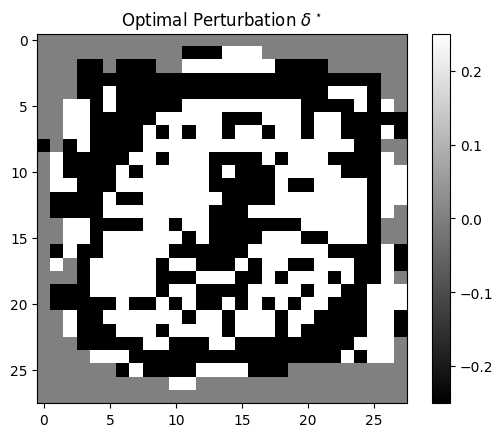

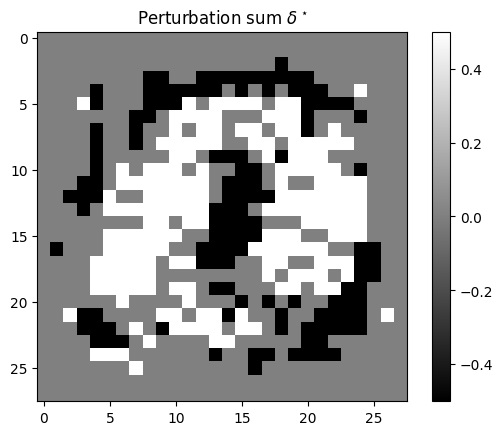

In [ ]:
# Plotting the optimal perturbation for the robust model
w = robust_lr.w

delta_star_robust = -epsilon * np.sign(w)


plt.imshow(delta_star_robust.reshape(28, 28), cmap = 'gray')
plt.title("Optimal Perturbation $\delta^\star$")
plt.colorbar()
plt.show()

plt.imshow(delta_star_robust.reshape(28, 28)+delta_star.reshape(28, 28), cmap = 'gray')
plt.title("Perturbation sum $\delta^\star$")
plt.colorbar()
plt.show()

#В целом, происходит то же, что и раньше -- затемняются характерные для нуля и единички признаки, а шумовые клетки усиливаются
#Наложение двух пертурбаций друг на друга, в целом, показывает то же самое.